In [1]:
import parselmouth as pm
import fasttrackpy.tracking
import numpy as np
from IPython.display import Image
import plotly.graph_objects as go
import pandas as pd
import time

Read in the sound file with parselmouth

In [2]:
sound = pm.Sound("assets/ay.wav")

Get all candidate formant tracks

In [3]:
all_candidates = fasttrackpy.tracking.all_tracks(sound, 
                                                 start = 5000,
                                                 stop = 8000,
                                                 nstep=20,
                                                 n_formants=5.5)

all_candidates.shape                                                 

(5, 769, 20)

Focus on just F1 through F4

In [4]:
eval_candidates = all_candidates[0:4, :, :]

Just running `fasttrackpy.tracking.choose_winner()` returns the winning index, but I'm also explicitly running `fasttrackpy.tracking.smooth_formants()` to get the smooths

The default smoother right now is the `dct_smooth()` in `fasttrackpy.smoothers`. It fits a discrert cosine transform to each formant. Then, it takes the top N (default 5) coefficients, and runs the inverse dct on those to return the smoothed formant tracks.

In [5]:
smoothed = fasttrackpy.tracking.smooth_formants(eval_candidates)

Get winner index. This takes uses a smoother, a loss function, and an aggregator function.

- default smoother: dct_smooth
- default loss: mean squared log error `lmse()`
- default aggregator: sum

`lmse()` takes the log of both the original formant track and the smooths. My reasoning here was that the range of variability is greater at higher frequencies, so their roughness would unduely influence the total error. Taking the log first will also emphasize smoothness for lower formants, which is usually where analysis is done.

There's also a normal means squared error `mse()` in `fasttrackpy.losses` that can be subbed in. 

In [6]:
winner_idx = fasttrackpy.tracking.choose_winner(eval_candidates)
winner_idx

10

Thus concludes implemented fasttrack code. Here's my sloppy plotting code to see the results.

In [7]:
winner_track = eval_candidates[:, :, winner_idx]
winner_smooth = smoothed[:, :, winner_idx]
time_domain = np.linspace(0, 1, num =winner_track.shape[1])

In [8]:
non_winner_track = eval_candidates[:, :, winner_idx+2]
non_winner_smooth = smoothed[:, :,  winner_idx+2]

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_domain, y=winner_track[0,:],
                    mode='markers',
                    name='f1'))
fig.add_trace(go.Scatter(x=time_domain, y=winner_track[1,:],
                    mode='markers',
                    name='f2'))
fig.add_trace(go.Scatter(x=time_domain, y=winner_track[2,:],
                    mode='markers',
                    name='f3'))                    
fig.add_trace(go.Scatter(x=time_domain, y=winner_smooth[0,:],
                    mode='lines',
                    name='f1_smooth'))
fig.add_trace(go.Scatter(x=time_domain, y=winner_smooth[1,:],
                    mode='lines',
                    name='f2_smooth'))
fig.add_trace(go.Scatter(x=time_domain, y=winner_smooth[2,:],
                    mode='lines',
                    name='f3_smooth'))
fig.update_layout(
    title="Winning Track",
)
fig.show()  

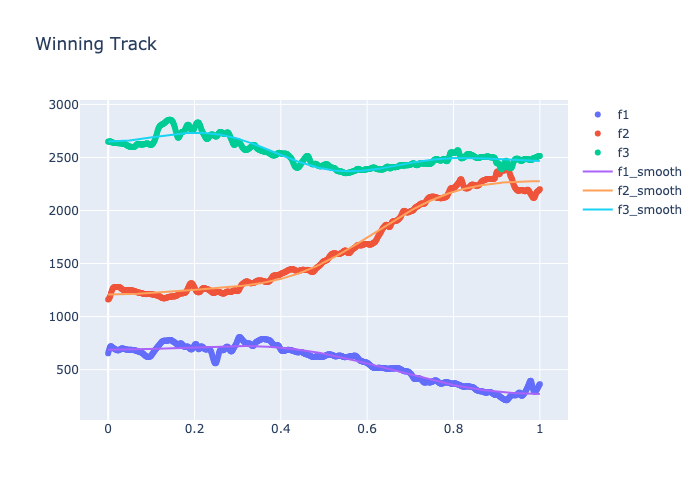

In [10]:
## static version
winner_bytes = fig.to_image(format = "png")
Image(winner_bytes)

In [11]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=time_domain, y=non_winner_track[0,:],
                    mode='markers',
                    name='f1'))
fig2.add_trace(go.Scatter(x=time_domain, y=non_winner_track[1,:],
                    mode='markers',
                    name='f2'))
fig2.add_trace(go.Scatter(x=time_domain, y=non_winner_track[2,:],
                    mode='markers',
                    name='f3'))                    
fig2.add_trace(go.Scatter(x=time_domain, y=non_winner_smooth[0,:],
                    mode='lines',
                    name='f1_smooth'))
fig2.add_trace(go.Scatter(x=time_domain, y=non_winner_smooth[1,:],
                    mode='lines',
                    name='f2_smooth'))
fig2.add_trace(go.Scatter(x=time_domain, y=non_winner_smooth[2,:],
                    mode='lines',
                    name='f3_smooth')) 
fig2.update_layout(
    title="A non winning track",
)                                                           
fig2.show()

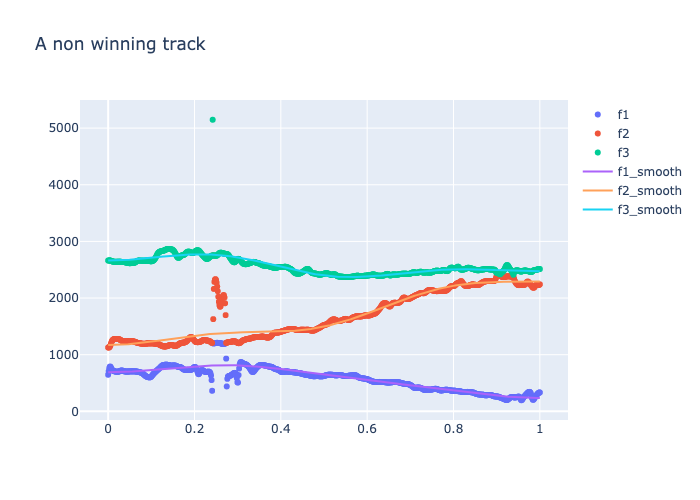

In [12]:
## static version
non_winning = fig2.to_image(format = "png")
Image(non_winning)